In [1]:
%matplotlib inline
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def printmd(data):
    display(Markdown(data))

In [3]:
# loop time
LOOP_TIME = 10000 / 1e6
LOOP_TIME

0.01

In [4]:
columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az', 'angx', 'angy', 'angz']
data = []
with open('./data_2.txt', 'r') as f:
    data = [l.strip()[:-1] for l in f.readlines() if len(l.strip()) > 0]
data = [[float(_d) for _d in d.split(',')] for d in data]
data = np.array(data)
df_raw_data = pd.DataFrame(data=data, columns=columns)
df_raw_data

,gx,gy,gz,ax,ay,az,angx,angy,angz
0,0.11,0.03,0.03,-0.14,-0.07,9.41,-0.32,-0.88,-0.13
1,0.12,0.00,-0.06,-0.13,-0.06,9.49,-0.32,-0.88,-0.13
2,0.08,-0.06,0.00,-0.15,-0.07,9.50,-0.32,-0.88,-0.13
3,0.09,0.08,0.03,-0.15,-0.07,9.44,-0.32,-0.88,-0.13
4,0.02,0.00,-0.05,-0.12,-0.06,9.47,-0.32,-0.88,-0.13
...,...,...,...,...,...,...,...,...,...
3026,0.00,0.06,-0.06,-0.11,-0.06,9.40,-0.30,-0.85,-4.78
3027,0.08,0.00,-0.03,-0.14,-0.04,9.50,-0.30,-0.85,-4.78
3028,0.00,-0.03,0.03,-0.14,-0.05,9.48,-0.30,-0.85,-4.78
3029,0.12,-0.03,-0.06,-0.13,-0.08,9.41,-0.30,-0.85,-4.78


In [5]:
data = [[0,0,0]]
# for 
for d in df_raw_data[['gx', 'gy', 'gz']].values:
    data.append([
        data[-1][0] + d[0] * LOOP_TIME,
        data[-1][1] + d[1] * LOOP_TIME,
        data[-1][2] + d[2] * LOOP_TIME
    ])
data = np.array(data[1:])

df_gyro_angle = pd.DataFrame(data=data, columns=['x', 'y', 'z'])

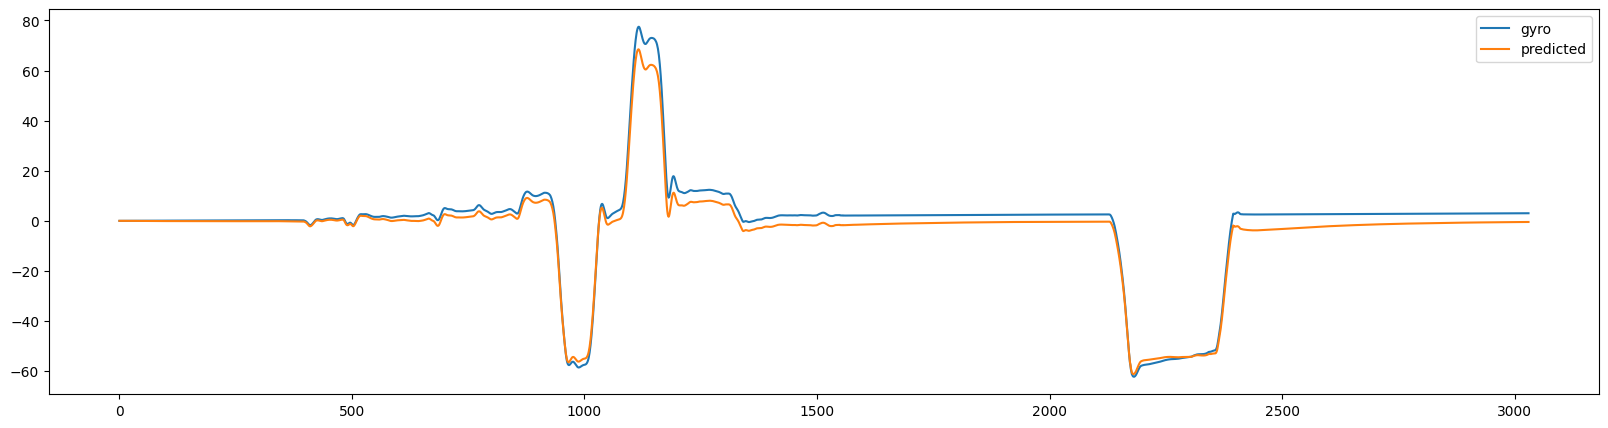

In [10]:
# state = np.array([0,0,0]).reshape(-1,1)
# P = np.eye(3)
# Q = np.diag([0.01, 0.01, 0.00])
# R = np.diag([0.1, 0.1, 0.1])
# prev_accel_angle = np.array([0,0,0]).reshape(-1,1)
# alpha = 0.96


class ExtendedKalmanFilter:

    def __init__(self, P, Q, R, alpha):
        self.state = np.array([0,0,0]).reshape(-1,1)
        self.P = P
        self.Q = Q
        self.R = R
        self.prev_accel_angle = np.array([0,0,0]).reshape(-1,1)
        self.alpha = alpha
    
    def ekf_update(self, gyro, accl_angle):
        global state
        global P
        global Q
        global R
        global prev_accel_angle
        global alpha
        
        self.state = self.state + gyro * LOOP_TIME
        self.P = self.P + self.Q
    
    
    
        # accl_angle =  self.prev_accel_angle*self.alpha + (1 - self.alpha)*accl_angle
        accl_angle = (1 - self.alpha) * self.prev_accel_angle + self.alpha*accl_angle
        self.prev_accel_angle = accl_angle
        residual = accl_angle - self.state
        
        K = self.P.dot(np.linalg.inv(self.P + self.R))
        self.state = self.state + K.dot(residual)
        self.P = (np.eye(3) - K).dot(self.P)
        return self.state
    
# P = np.eye(3)
# Q = np.diag([0.01, 0.01, 0.00])
# R = np.diag([1.1, 1.1, 1.1])
# alpha = 0.04

P = np.eye(3)
# Q = np.diag([0.02318644, 0.02318644, 0.0])
Q = np.diag([0.002, 0.002, 0.0])
R = np.diag([100, 100, 100])
alpha = 0.04



ekf = ExtendedKalmanFilter(P, Q, R, alpha)

ekf_states = []

for i in range(df_raw_data.shape[0]):
    row = df_raw_data.iloc[i]
    gyro_data = row[['gx', 'gy', 'gz']].values.reshape(-1,1)
    accl_data = row[['ax', 'ay', 'az']].values
    accl_angle = np.rad2deg(np.array([
        np.arctan(accl_data[1] / np.sqrt(accl_data[0]**2 + accl_data[2]**2)),
        np.arctan(-accl_data[0] / np.sqrt(accl_data[1]**2 + accl_data[2]**2)),
        0
    ]))
    accl_angle = accl_angle.reshape(-1,1)
    updated_state = ekf.ekf_update(gyro_data, accl_angle)
    ekf_states.append(updated_state.reshape(3))

ekf_states = pd.DataFrame(data=np.array(ekf_states), columns=['x', 'y', 'z'])

plot_data = [
    [df_gyro_angle['x'], 'gyro'],
    [ekf_states['x'], 'predicted'],
    # [df_raw_data['angy'], 'received angx'],
    # [df_raw_data['pidx'], 'pidx']
]

plt.figure(figsize=(20, 5))
for d, _ in plot_data:
    plt.plot(d)
plt.legend([p[1] for p in plot_data])
plt.show()


In [21]:
df_gyro_angle['x'].values[-100], ekf_states['x'].values[-100]

(2.9471999999999787, -0.6196680495252597)